In [ ]:
# Install PySpark and findspark
!pip install -q findspark



ERROR: Operation cancelled by user


In [ ]:
!pip install sparkxgb

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sparkxgb: filename=sparkxgb-0.2-py3-none-any.whl size=5629 sha256=70294a349e8fdb38a7f354f92b21904774429abdc7a698ef378bd4dcb07b1156
  Stored in directory: /root/.cache/pip/wheels/f9/e5/73/8b34b9b0ba0e0793033077ead4ec8cb93329bcc71d53cfd7fc
  Created wheel for pyspark: filename=pyspark-3.5.4-py2.py3-none-any.whl size=317849769 sha256=c1a928b5f356675293155a80aaf8c3c096bc606ae8d54c3f9238c8592c6457d2
  Stored in directory: /root/.cache/pip/wheels/8d/28/22/5dbae8a8714ef046cebd320d0ef7c92f5383903cf854c15c0c
Successfully built sparkxgb pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.5
    Uninstalling pyspark-3.5.5:
      Successfully uninstalled pyspark-3.5.5


In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import sparkxgb


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("GPU_Enabled_Spark") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()


In [ ]:
from pyspark.sql.functions import rand
import os, shutil
from google.colab import files

# Step 1: Load Parquet file
parquet_path = '/content/drive/MyDrive/Customeranalysis/part-00000-bc34bbb5-8bd9-48b4-b7b8-7dabcfd43015-c000.snappy.parquet'
df = spark.read.parquet(parquet_path)

# Step 2: Limit and sample 500 random rows
df = df.limit(10000).orderBy(rand()).limit(500)






<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from pyspark.sql.functions import col

# Convert the sales columns to numeric (float type)
sales_columns = ['sales_after_discount_d_9', 'sales_after_discount_d_10', 'sales_after_discount_d_11']

# Convert the sales columns to float
for column in sales_columns:
    df = df.withColumn(column, col(column).cast('float'))

# Create the churn column: churn if 2 or more of the last 3 months have 0 sales
df = df.withColumn('churned',
                   ( (col('sales_after_discount_d_9') == 0).cast('int') +
                     (col('sales_after_discount_d_10') == 0).cast('int') +
                     (col('sales_after_discount_d_11') == 0).cast('int') ) >= 2 )

In [ ]:
Exploratory Data Analysis

# Exploratory Data Analysis

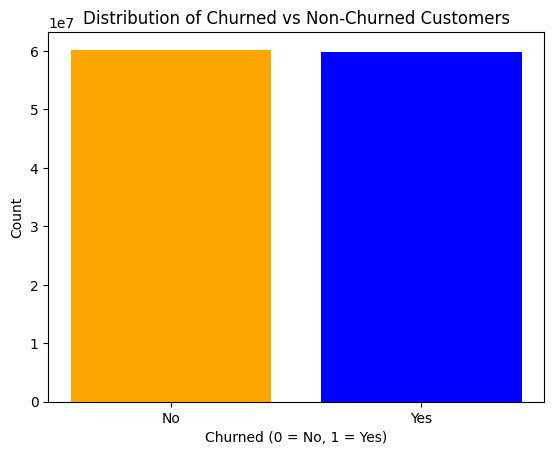

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of churned vs. non-churned customers
churn_count = df.groupBy('churned').count().toPandas()

plt.bar(churn_count['churned'], churn_count['count'], color=['blue', 'orange'])
plt.xlabel('Churned (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.title('Distribution of Churned vs Non-Churned Customers')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()


In [ ]:
# Assemble features into a single vector column
assembler = VectorAssembler(
    inputCols=[col for col in selected_columns if col != 'churned'],
    outputCol="features"
)
df_features = assembler.transform(df_selected)

# Cast churned column into integer
df_features = df_features.withColumn("churned", col("churned").cast("integer"))


In [ ]:
# Split the data into training and test sets
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)


In [ ]:
predictions = model.transform(test_data)


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="churned")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc:.3f}")


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Make predictions
predictions = model.transform(test_data)

# Convert predictions to RDD of (prediction, label)
prediction_and_labels = predictions.select("prediction", "churned").rdd.map(lambda row: (float(row[0]), float(row[1])))

# Compute confusion matrix
metrics = MulticlassMetrics(prediction_and_labels)
conf_matrix = metrics.confusionMatrix().toArray()

print("Confusion Matrix:")
print(conf_matrix)


In [ ]:
# Get feature importances
weights = model.coefficients
features = assembler.getInputCols()

print("\nFeature Weights:")
for feature, weight in zip(features, weights):
    print(f"{feature}: {weight:.4f}")


In [ ]:
#new code run from here

In [ ]:
import pandas as pd

df = pd.read_csv('/content/sample_500.csv')


In [ ]:
df.info()
df.describe()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 148 entries, external_code to total_sales_after_discount
dtypes: float64(29), int64(112), object(7)
memory usage: 578.3+ KB


,external_code,date,customer,qty,long sleeve,culottes,miniskirt,short sleeves,printed shirt,short cardigan,...,sales_after_discount_d_5,sales_after_discount_d_6,sales_after_discount_d_7,sales_after_discount_d_8,sales_after_discount_d_9,sales_after_discount_d_10,sales_after_discount_d_11,sales_after_discount_d_12,total_sales_before_discount,total_sales_after_discount
0,101,2017-07-03,119101,1,42,87,52,79,66,55,...,0.548194,0.548194,0.548194,0.548194,0.548194,0.548194,0.548194,0.548194,5.96,5.731991
1,101,2017-07-24,253496,1,45,84,52,65,66,51,...,0.548194,0.548194,0.548194,0.548194,0.548194,0.548194,0.548194,0.548194,68.96,66.321834
2,101,2017-07-17,352874,1,44,78,100,77,68,55,...,0.548194,0.548194,0.548194,0.548194,0.548194,0.548194,0.548194,0.548194,5.96,5.731991
3,81,2017-02-13,170866,1,48,57,53,59,64,38,...,0.000000,0.230767,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.25,11.307599
4,85,2017-03-06,242706,1,50,52,37,68,72,32,...,0.107584,0.107584,0.107584,0.107584,0.107584,0.107584,0.107584,0.107584,39.99,39.111640


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define sales columns
sales_columns = ['sales_after_discount_d_9', 'sales_after_discount_d_10', 'sales_after_discount_d_11']

# Convert sales columns to float
df[sales_columns] = df[sales_columns].astype(float)

# Create churn column: churn = 1 if 2 or more of the last 3 months have 0 sales
df['churned'] = ((df[sales_columns] == 0).sum(axis=1) >= 2).astype(int)

# Select features
selected_columns = [
    'qty', 'price', 'total_sales_after_discount',
    'sales_after_discount_d_1', 'sales_after_discount_d_2', 'sales_after_discount_d_3',
    'sales_after_discount_d_4', 'sales_after_discount_d_5', 'sales_after_discount_d_6',
    'sales_after_discount_d_7', 'total_sales_before_discount', 'churned'
]

# Drop rows with missing values
df_selected = df[selected_columns].dropna()

# Split features and target
X = df_selected.drop('churned', axis=1)
y = df_selected['churned']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train logistic regression
lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.98      0.92        53
           1       0.97      0.83      0.90        47

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100



Confusion Matrix:
 [[52  1]
 [ 8 39]]


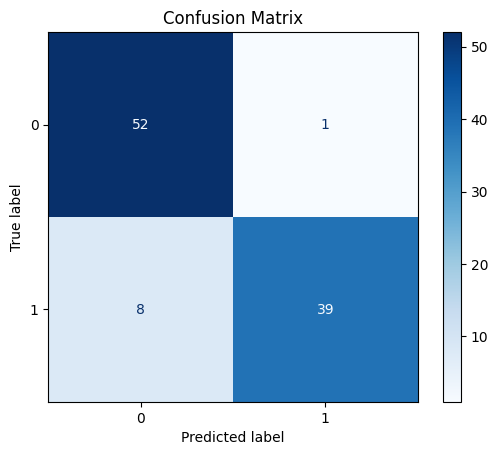

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it as a text matrix
print("Confusion Matrix:\n", cm)

# Optional: Visualize it using a heatmap-style plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()
